In [8]:
#!nvidia-smi

# Импортирование библиотек

In [4]:
import time
import cv2
from datetime import datetime
from tqdm import tqdm
from PIL import ImageOps, ImageFilter
import PIL
import os
import sys
import random as rn
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, \
                                    ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, \
                                    Activation, Lambda, BatchNormalization,SeparableConv2D,\
                                    GlobalAveragePooling2D, LSTM,InputLayer, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(keras.__version__)

2.7.0
2.7.0


In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Основные настройки

In [4]:
path_train = 'B:/STARS/train/'
path_train_0 = 'B:/STARS/train/0/'
path_train_1 = 'B:/STARS/train/1/'

path_test = 'B:/STARS/test/'
path_test_0 = 'B:/STARS/test/0/'
path_test_1 = 'B:/STARS/test/1/'

RANDOM_SEED = 42

IMG_SIZE             = 256 # какого размера подаем изображения в сеть
IMG = IMG_SIZE * IMG_SIZE
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
EPOCHS = 200

# EDA + Подготовка данных

In [5]:
sum_train = len(os.listdir(path_train_0)) + len(os.listdir(path_train_1))
sum_test = len(os.listdir(path_test_0)) + len(os.listdir(path_test_1))

print(f'( {len(os.listdir(path_train_0))} , {round(len(os.listdir(path_train_0))/sum_train,2)} ) || ( {len(os.listdir(path_train_1))} , {round(len(os.listdir(path_train_1))/sum_train,2)} )  {sum_train}')
print(f'( {len(os.listdir(path_test_0))} , {round(len(os.listdir(path_test_0))/sum_test,2)} ) || ( {len(os.listdir(path_test_1))} , {round(len(os.listdir(path_test_1))/sum_test,2)} )  {sum_test}')

( 2781 , 0.5 ) || ( 2800 , 0.5 )  5581
( 1206 , 0.5 ) || ( 1187 , 0.5 )  2393


In [6]:
def print_all_classes():
    
    
    '''Вывод 1й картинки каждого класса машин'''

    
    cols = 5
    rows = 2
    fig = plt.figure(figsize=(4 * cols - 1, 4 * rows - 1))

    count = 0
    for i in range(cols):
        for j in range(rows):
            if count <5:
                image = PIL.Image.open(
                    path_train+'0/'+os.listdir(path_train+'0/')[count],
                    formats=['PNG'])
            else:
                image = PIL.Image.open(
                    path_train+'1/'+os.listdir(path_train+'1/')[count],
                    formats=['PNG'])
            ax = fig.add_subplot(rows, cols, i * rows + j + 1)
            ax.grid('off')
            ax.axis('off')
            ax.imshow(image, cmap='gray')
            if count <5:
                ax.set_title(f'Category: 0')
            else:
                ax.set_title(f'Category: 1')
            count += 1

    plt.show()

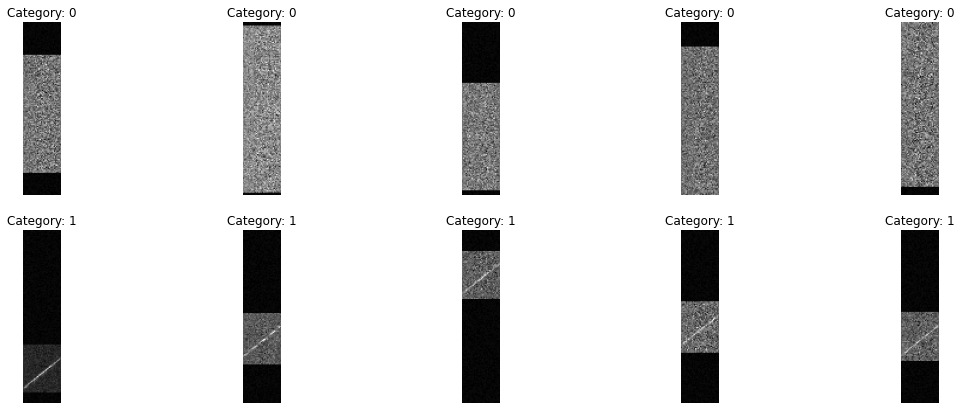

In [7]:
print_all_classes()

In [8]:
# 0
# max 4884 || (148.0, 33) 
# min 792 || (24.0, 33) 
#  1
# max 4587 || (139.0, 33) 
# min 792 || (24.0, 33) 

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=(148,32),
    color_mode='grayscale',
    interpolation = 'nearest',
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True)
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=(148,32),
    color_mode='grayscale',
    interpolation = 'nearest',
    batch_size=BATCH_SIZE,
    class_mode='binary')

Found 5581 images belonging to 2 classes.
Found 2393 images belonging to 2 classes.


In [10]:
training_dataset_size = train_generator.samples
testing_dataset_size = test_generator.samples
print(training_dataset_size,testing_dataset_size)

5581 2393


In [11]:
len_gen_tr = len(train_generator)
len_gen_t = len(test_generator)

In [12]:
iter(train_generator)[0][0].shape

(64, 148, 32, 1)

In [13]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(BATCH_SIZE):
        if n <10:
            ax = plt.subplot(2, 5,n+1)
            plt.imshow(image_batch[n],cmap='gray')
            if label_batch[n]:
                plt.title("1")
            else:
                plt.title("0")
            plt.axis("off")
        else:
            break

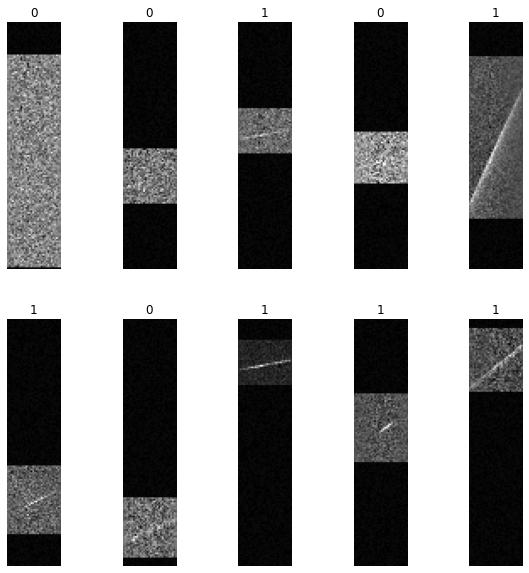

In [14]:
image_batch, label_batch = next(iter(train_generator))

show_batch(image_batch, label_batch)

In [15]:
print(image_batch.shape, label_batch.shape)

(64, 148, 32, 1) (64,)


# Построение модели

In [26]:
tf.keras.backend.clear_session()

In [16]:
optm = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [18]:
model = Sequential(name = "RNN")
model.add(Reshape(target_shape=(148,32),input_shape=(148,32,1)))
model.add(LSTM(64,input_shape = (148,32),return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64,return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 148, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 148, 64)           24832     
_________________________________________________________________
dropout (Dropout)            (None, 148, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0       

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=optm,
              metrics=['accuracy'])

checkpoint_model = ModelCheckpoint('B:/STARS/model/stars_model.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             mode='max',
                             save_best_only=True,
                             save_weights_only=False)

earlystop_model = EarlyStopping(monitor='val_accuracy',
                          patience=20,
                          verbose=1,
                          mode='max',
                          baseline=None,
                          restore_best_weights=True)

In [21]:
model_history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator,
                    epochs=EPOCHS,
                    callbacks=[checkpoint_model, earlystop_model])

Epoch 1/200
87/87 [==============================] - 12s 75ms/step - loss: 0.6818 - accuracy: 0.5249 - val_loss: 0.6785 - val_accuracy: 0.5516

Epoch 00001: val_accuracy improved from -inf to 0.55161, saving model to B:/SKILL_FACTORY/STARS/model\stars_model.h5
Epoch 2/200
87/87 [==============================] - 6s 64ms/step - loss: 0.6731 - accuracy: 0.5765 - val_loss: 0.6685 - val_accuracy: 0.5834

Epoch 00002: val_accuracy improved from 0.55161 to 0.58337, saving model to B:/SKILL_FACTORY/STARS/model\stars_model.h5
Epoch 3/200
87/87 [==============================] - 5s 61ms/step - loss: 0.6536 - accuracy: 0.6186 - val_loss: 0.6400 - val_accuracy: 0.6498

Epoch 00003: val_accuracy improved from 0.58337 to 0.64981, saving model to B:/SKILL_FACTORY/STARS/model\stars_model.h5
Epoch 4/200
87/87 [==============================] - 5s 60ms/step - loss: 0.6025 - accuracy: 0.6937 - val_loss: 0.5590 - val_accuracy: 0.7376

Epoch 00004: val_accuracy improved from 0.64981 to 0.73757, saving mod

87/87 [==============================] - 5s 59ms/step - loss: 0.2290 - accuracy: 0.9085 - val_loss: 0.2678 - val_accuracy: 0.8901

Epoch 00072: val_accuracy did not improve from 0.89762
Epoch 73/200
87/87 [==============================] - 5s 60ms/step - loss: 0.2385 - accuracy: 0.9030 - val_loss: 0.2556 - val_accuracy: 0.9014

Epoch 00073: val_accuracy improved from 0.89762 to 0.90138, saving model to B:/SKILL_FACTORY/STARS/model\stars_model.h5
Epoch 74/200
87/87 [==============================] - 5s 60ms/step - loss: 0.2259 - accuracy: 0.9059 - val_loss: 0.2695 - val_accuracy: 0.8901

Epoch 00074: val_accuracy did not improve from 0.90138
Epoch 75/200
87/87 [==============================] - 5s 63ms/step - loss: 0.2305 - accuracy: 0.9081 - val_loss: 0.2617 - val_accuracy: 0.8930

Epoch 00075: val_accuracy did not improve from 0.90138
Epoch 76/200
87/87 [==============================] - 6s 64ms/step - loss: 0.2226 - accuracy: 0.9088 - val_loss: 0.2737 - val_accuracy: 0.8930

Epoch 00

87/87 [==============================] - 5s 62ms/step - loss: 0.1582 - accuracy: 0.9369 - val_loss: 0.1794 - val_accuracy: 0.9327

Epoch 00149: val_accuracy improved from 0.93188 to 0.93272, saving model to B:/SKILL_FACTORY/STARS/model\stars_model.h5
Epoch 150/200
87/87 [==============================] - 5s 62ms/step - loss: 0.1711 - accuracy: 0.9322 - val_loss: 0.1948 - val_accuracy: 0.9290

Epoch 00150: val_accuracy did not improve from 0.93272
Epoch 151/200
87/87 [==============================] - 6s 70ms/step - loss: 0.1565 - accuracy: 0.9386 - val_loss: 0.2123 - val_accuracy: 0.9227

Epoch 00151: val_accuracy did not improve from 0.93272
Epoch 152/200
87/87 [==============================] - 5s 60ms/step - loss: 0.1633 - accuracy: 0.9358 - val_loss: 0.2134 - val_accuracy: 0.9135

Epoch 00152: val_accuracy did not improve from 0.93272
Epoch 153/200
87/87 [==============================] - 5s 52ms/step - loss: 0.1513 - accuracy: 0.9404 - val_loss: 0.1961 - val_accuracy: 0.9265

Epoc

In [22]:
model.save('B:/STARS/model/stars_model_1.h5')

In [27]:
model = tf.keras.models.load_model('B:/STARS/model/stars_model_93774.h5')

In [28]:
test_data = []
for filename in os.listdir(path_test_0):
    test_data.append((os.path.join(path_test_0,filename),0))
    
for filename in os.listdir(path_test_1):
    test_data.append((os.path.join(path_test_1,filename),1))
    
    

test_df = pd.DataFrame(test_data, columns = ['img_path','label'], index = None)

In [29]:
def predict(image_path, model):
    im = PIL.Image.open(image_path)
    im = im.convert("L")
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = -1)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
    
def process_image(image):
    image = image/255
    #image = cv2.resize(image, (32,148))
    return image



def testing(model, test_df):
    """ the passed data must be the img_path columns and label column"""
    base_pred =[]
    for image in test_df.img_path:
        base_pred.append(predict(image , model)[0][0])
    
    base_pred = [int(i>0.95) for i in base_pred]
    actual_label = test_df['label']
    # print(final_base_pred)

    print(classification_report(actual_label, base_pred))
    matrix=confusion_matrix(actual_label, base_pred)
    sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1206
           1       0.99      0.74      0.85      1187

    accuracy                           0.87      2393
   macro avg       0.89      0.87      0.86      2393
weighted avg       0.89      0.87      0.86      2393



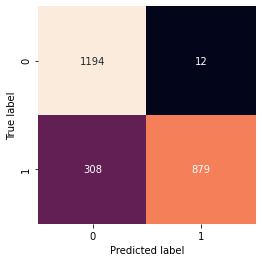

In [30]:
testing(model, test_df)